In [1]:
%matplotlib inline
import random
import matplotlib.pyplot as plt
import numpy as np
import copy

In [2]:
def get_reward(state):
    if state == 'rterm':
        return 1.
    else:
        return 0.
    
def td_zero(no_episodes, states, gamma=0.99, alpha=0.1):
    V = np.zeros(len(states))
    E = np.zeros(len(states))
    for _ in range(no_episodes):
        s = len(states) // 2   # initialize start_state_index
        while states[s] not in terminals:
            action = -1 if random.randint(0, 1) else 1    # random policy
            next_s = s + action # next state index
            reward = get_reward(states[next_s])
            delta = alpha * (reward + gamma * V[next_s] - V[s])
            V[s] = V[s] + delta
            s = next_s
    return V

## 19-state Random walk experiment with eligibility traces (TD($\lambda$))

<img src='online_TD_lambda.png'>

In [3]:
def td_lambda(no_episodes, states, rule, gamma=0.99, alpha=0.5, lam=0.9):
    V = np.zeros(len(states))
    E = np.zeros(len(states))
    for _ in range(no_episodes):
        s = len(states) // 2   # initialize start_state_index
        while states[s] not in terminals:
            action = -1 if random.randint(0, 1) else 1    # random policy
            next_s = s + action # next state index
            reward = get_reward(states[next_s])
            delta = reward + gamma * V[next_s] - V[s]
            if rule == 'accumulation':
                E[s] = E[s] + 1
            elif rule == 'replacing':
                E[s] = 1
            elif rule == 'dutch':
                E[s] = (1-alpha) * E[s] + 1
            else:
                raise ValueError('Rule must be defined.')
            # for each state, we update the values and traces.
            V = V + (alpha * delta * E)
            E = gamma * lam * E
            
            s = next_s
    return V

<img src="fig7_16.png">

In [4]:
states = list(range(19))
terminals = ('lterm', 'rterm')
states = [terminals[0]] + states + [terminals[1]]

In [5]:
V_accum = td_lambda(100, states, rule='accumulation')
V_replace = td_lambda(100, states, rule='replacing')
V_tdzero = td_zero(100, states)
V_dutch = td_lambda(100, states, rule='dutch')

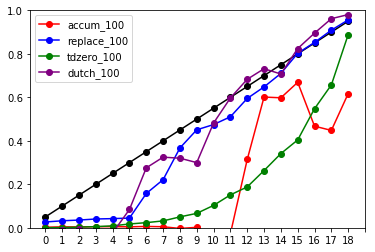

In [6]:
plt.plot([i/(len(states)-1) for i in range(1, len(states)-1)], 'ko-')
plt.plot([V_accum[x] for x in range(1, len(states)-1)], 'ko-', color='red', label='accum_100')
plt.plot([V_replace[x] for x in range(1, len(states)-1)], 'ko-', color='blue', label='replace_100')
plt.plot([V_tdzero[x] for x in range(1, len(states)-1)], 'ko-', color='green', label='tdzero_100')
plt.plot([V_dutch[x] for x in range(1, len(states)-1)], 'ko-', color='purple', label='dutch_100')

plt.xticks(range(len(states)-1), states[1:-1])
plt.ylim([0,1])
plt.legend(loc='best')

In [7]:
True_Vs = np.array([i/(len(states)-1) for i in range(1, len(states)-1)])
errs_accum = []
errs_replace = []
errs_dutch = []
errs_tdzero = []
for n in range(30):
    errs_accum.append(np.sum(np.square(True_Vs-td_lambda(100, states, rule='accumulation')[1:-1])))
    errs_replace.append(np.sum(np.square(True_Vs-td_lambda(100, states, rule='replacing')[1:-1])))
    errs_dutch.append(np.sum(np.square(True_Vs-td_lambda(100, states, rule='dutch')[1:-1])))
    errs_tdzero.append(np.sum(np.square(True_Vs-td_zero(100, states)[1:-1])))
print('TD_accum:', np.mean(errs_accum))
print('TD_replace:', np.mean(errs_replace))
print('TD_dutch', np.mean(errs_dutch))
print('TD_tdzero', np.mean(errs_tdzero))

TD_accum: 1.2814772060968787
TD_replace: 0.5817941854144847
TD_dutch 0.6730183025363822
TD_tdzero 1.9592073825059726


<img src="fig7_9.PNG" width="600" align="left">

In [8]:
lams = [0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.975, 0.99, 1]
results = []
TV = np.array([i/(len(states)-1) for i in range(1, len(states)-1)])
for lam in lams:
    temp = []
    for _ in range(10):
        V = td_lambda(10, states, rule='replacing', alpha=0.5, lam=lam)[1:-1]
        rms = np.sqrt(np.square(TV-V))  # root-mean-squared-error
        avg_error_states = np.mean(rms)
        temp.append(avg_error_states)
    results.append(np.mean(temp))

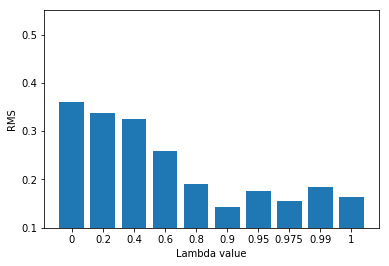

In [9]:
plt.close()
plt.bar(range(len(results)), results)
plt.xticks(range(len(results)), lams)
plt.ylim([0.1,0.55])
plt.xlabel('Lambda value')
plt.ylabel('RMS')